# K-means classification
In this notebook we are going to try a clustering algorithm for classification
## Loading the data
We are going to use the clustered in the 4.0 notebook:

In [1]:
# Importing main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Importing the data 
df = pd.read_csv('../data/RD_dataset.csv')
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


## Pre-processing
Separating the dataframe and preparing for training

In [3]:
from sklearn.preprocessing import MinMaxScaler
from benchtools.src.datatools import separate_data
from sklearn.model_selection import train_test_split

In [4]:
# Separating characteristics from label
X, y = separate_data(df, standarize=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminating the columns of mass so that the training is model-free 
# and eliminating the variables that differ the least
X_train_nm = X_train.drop(['m_j1', 'm_j2', 'm_jj','eta_j1', 'E_j1', 'phi_j1', 'eta_j2', 'E_j2', 'phi_j2'], axis=1)
X_test_nm = X_test.drop(['m_j1', 'm_j2', 'm_jj', 'eta_j1', 'E_j1', 'phi_j1', 'eta_j2', 'E_j2', 'phi_j2'], axis=1)

# Standarizing the variables
scaler = MinMaxScaler()
X_train_nm[X_train_nm.columns] = scaler.fit_transform(X_train_nm[X_train_nm.columns])
X_test_nm[X_test_nm.columns] = scaler.fit_transform(X_test_nm[X_test_nm.columns])

X_train_nm.head()

,pT_j1,tau_21_j1,nhadrons_j1,pT_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons
269950,0.023766,0.194259,0.177165,0.236204,0.187415,0.170732,0.468489,0.135043
501714,0.163466,0.288922,0.240157,0.329691,0.245672,0.178862,0.495242,0.184615
381639,0.073016,0.412827,0.244094,0.282658,0.184162,0.321138,0.446029,0.249573
449407,0.014362,0.493650,0.244094,0.242288,0.313793,0.272358,0.524856,0.244444
175477,0.066394,0.459898,0.074803,0.166781,0.703020,0.186992,0.533256,0.150427


We will use PCA to further reduce the dimensions

In [5]:
from sklearn.decomposition import PCA
# Reducing to 2 inputs
pca = PCA(n_components=2)
pca.fit(X_train_nm)

# Transforming the data to this inputs
X_pca_train = pca.transform(X_train_nm)
X_pca_train = pd.DataFrame(X_pca_train)

X_pca_test = pca.transform(X_test_nm)
X_pca_test = pd.DataFrame(X_pca_test)

## Training, classification and metrics
Let's see how the classifier does on this data

In [6]:
from sklearn.cluster import KMeans
from benchtools.src.metrictools import performance_metrics

log_cols=["Classifier", "Precision", "Recall", "F1 score", "Rand score"]
log = pd.DataFrame(columns=log_cols)

clf = KMeans(n_clusters=2, random_state=15)
# Getting the name
name = clf.__class__.__name__
# Training
clf.fit(X_pca_train)
# Obtaining predictions
y_pred = clf.predict(X_pca_test)
# Obtaining metrics
log = performance_metrics(name=name, label=y_test, pred_label=y_pred, pred_prob=None)

KMeans
****Results****
              precision    recall  f1-score   support

  background       0.98      0.66      0.79    139578
      signal       0.21      0.88      0.34     14022

    accuracy                           0.68    153600
   macro avg       0.59      0.77      0.56    153600
weighted avg       0.91      0.68      0.75    153600



In [7]:
log

,Classifier,Recall,Precision,F1 score
0,KMeans,0.881686,20.701954,0.335309


In [8]:
X_dist = clf.transform(X_pca_test)
dist_df = pd.DataFrame(X_dist)
dist_df = dist_df.assign(y_pred=pd.Series(y_pred).values)
dist_df = dist_df.assign(y_test=pd.Series(y_test).values)
dist_df.head()

,0,1,y_pred,y_test
0,0.427963,0.167145,1,0.0
1,0.225904,0.197226,1,0.0
2,0.305114,0.135326,1,0.0
3,0.316312,0.223727,1,0.0
4,0.333636,0.369849,0,0.0


### Plots
I'll do some plots using benchtools

In [9]:
from benchtools.src.metrictools import rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

In [10]:
bkg_dist = dist_df.loc[:,0]
sig_dist = dist_df.loc[:,1]
# The closest to the signal cluster center are the most likely to be signal
y_dist = 1-sig_dist

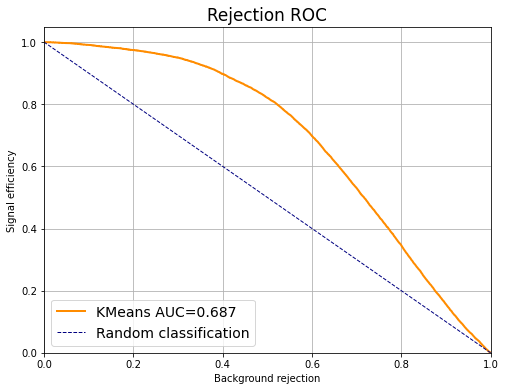

In [11]:
rejection_plot(names=name ,labels=y_test, probs=y_dist)
plt.show()

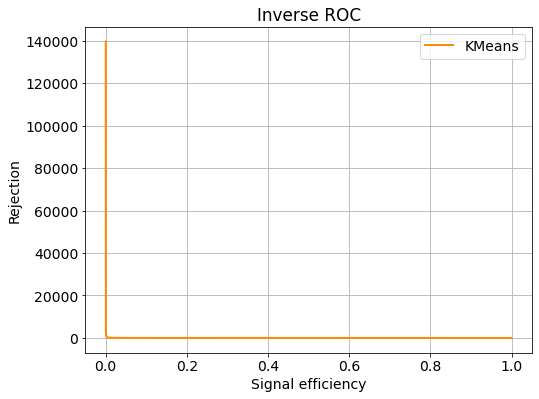

In [12]:
inverse_roc_plot(names=name ,labels=y_test, probs=y_dist)
plt.show()

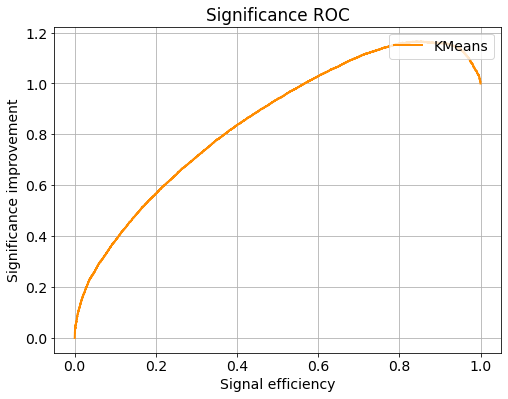

In [13]:
significance_plot(names=name ,labels=y_test, probs=y_dist)
plt.show()

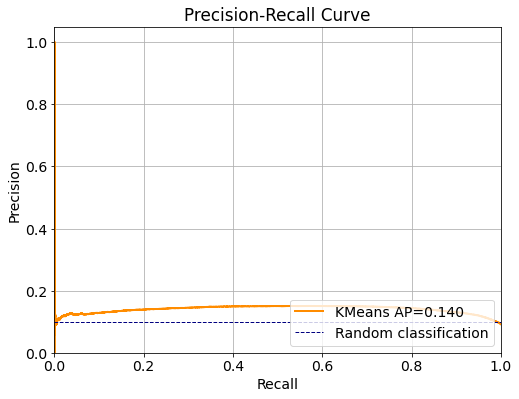

In [14]:
precision_recall_plot(names=name ,labels=y_test, probs=y_dist)
plt.show()

## Distributions
For the metrics we can see that the classification is weak. Let's plot the distributions to see what got as signal

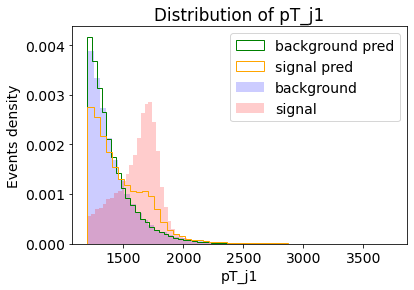

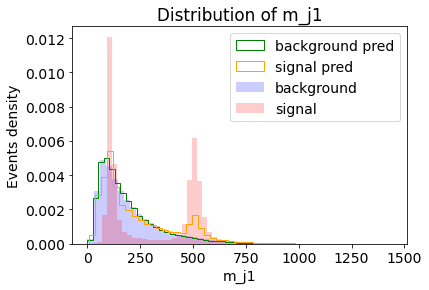

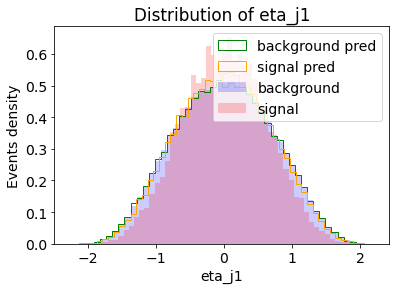

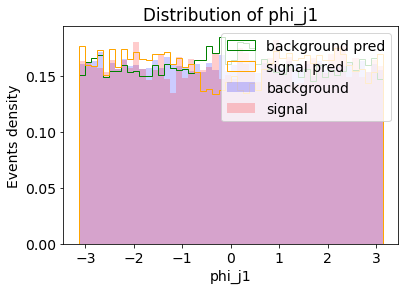

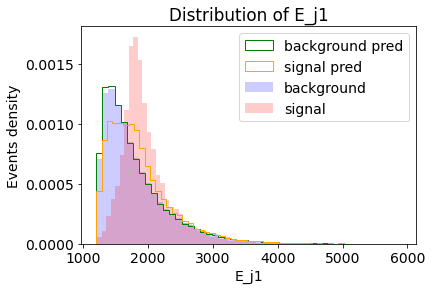

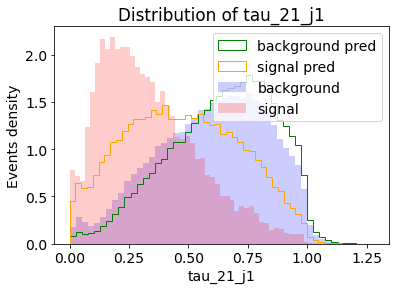

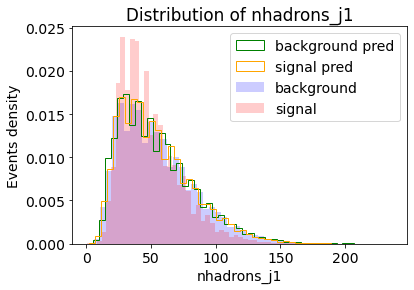

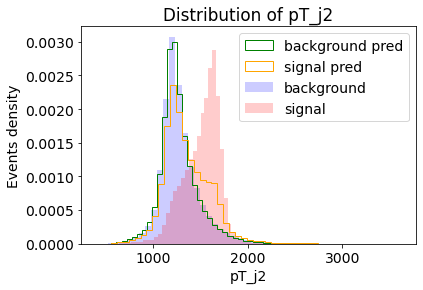

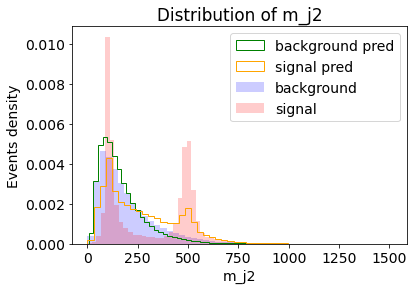

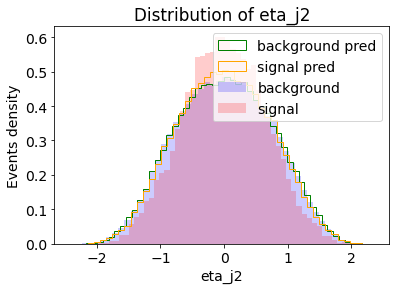

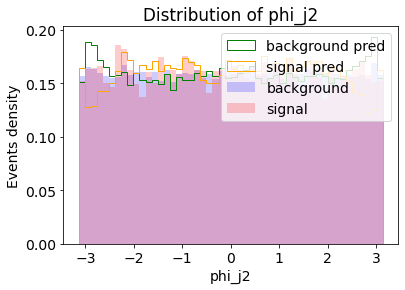

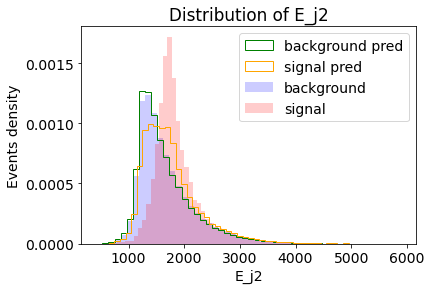

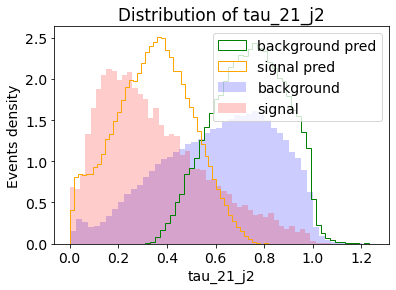

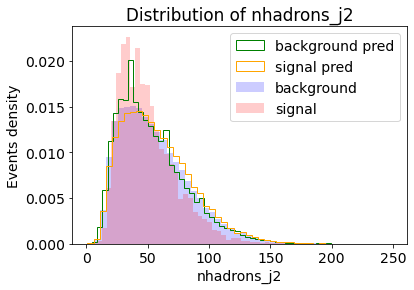

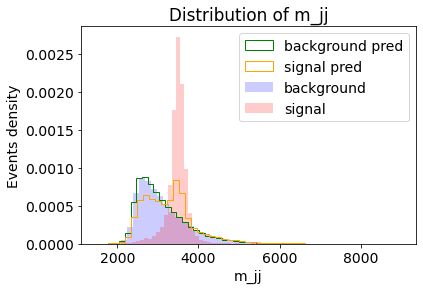

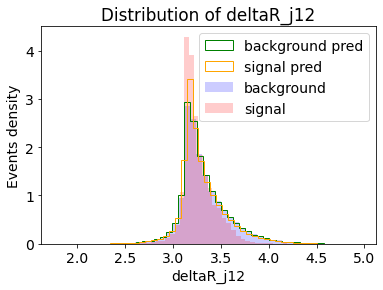

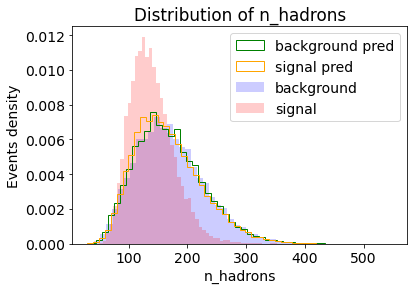

In [15]:
from benchtools.src.plotools import pred_test_hist

# Adding the series to the dataframe with the masses
X_test = X_test.assign(y_test=pd.Series(y_test).values)
X_test = X_test.assign(y_pred=pd.Series(y_pred).values)

variables=X_test.drop(['y_pred','y_test'], axis=1).columns.tolist()

for variable in variables:
    pred_test_hist(X_test, variable, ypred='y_pred', ytest='y_test', n_bins=50, log=False)

## Clusters
Let's plot the clusters to see how is it doing it. Firts, the clusters according to the classification

C:\Users\maria\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


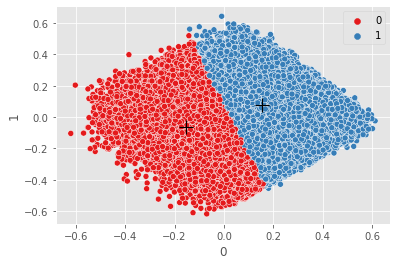

In [16]:
plt.style.use('ggplot')
import seaborn as sns

# training
kmeans = KMeans(n_clusters=2).fit(X_pca_test)

# plot the cluster samples and centers 
sns.scatterplot(x=X_pca_test.loc[:,0], y=X_pca_test.loc[:,1], hue=y_pred, 
                palette=sns.color_palette("Set1", n_colors=2));
sns.scatterplot(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], 
                marker='+', facecolor='black', s=200);

Now let's see how the data is truly distributed

C:\Users\maria\anaconda3\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


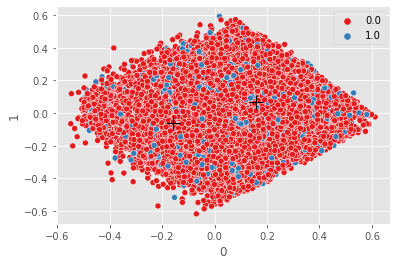

In [17]:
# training
kmeans = KMeans(n_clusters=2).fit(X_pca_test)

# plot the cluster samples and centers 
sns.scatterplot(x=X_pca_test.loc[:,0], y=X_pca_test.loc[:,1], hue=y_test, 
                palette=sns.color_palette("Set1", n_colors=2));
sns.scatterplot(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1], 
                marker='+', color='black', s=200);